# GROUP BY와 CTAS

>1. GROUP BY와 AGGREGATE함수
>2. CTAS와 CTE 소개 - 데이터 품질 확인
>3. assignment

## GROUP BY & Aggregate 함수 (1)
- 테이블의 레코드를 그룹핑하여 그룹별로 다양한 정보를 계산
- 이는 두 단계로 이뤄짐

1. 먼저 그룹핑을 할 필드를 결정 (하나 이상의 필드가 될 수 있음)
    - GROUP BY로 지정 (필드 이름을 사용하거나 필드 일련번호를 사용)
2. 다음 그룹별로 계산할 내용을 결정
    - 여기서 Aggregate함수를 사용
    - COUNT, SUM, AVG, MIN, MAX, LISTAGG, ...
        - 보통 필드 이름을 지정하는 것이 일반적 (alias)

##  GROUP BY & Aggregate 함수 (2)
- 월별 세션수를 계산하는 SQL
    - raw_data.session_timestamp를 사용 (sessionId와 ts 필드)
```sql
SELECT
LEFT(ts, 7) AS mon, -- ts 연도-월 (7자리)로 바뀜 , AS(optional) -> 필드값 이름을 mon으로 지정
COUNT(1) AS session_count -- 카운트한 값을 새 필드 값으로 지정.
FROM raw_data.session _timestamp
GROUP BY 1 -- GROUP BY mon 또는 GROUP BY LEFT(ts, 7) : 같은 표현
ORDER BY 1; -- 2 : session_count 작은 것부터 
-- 큰것부터 : 2 DESC (default : ASC)
```
***
- GROUP BY로 다음 문제를 풀어보자
- 앞서 설명한 raw_data.session_timestamp와
raw_data.user_session_channel 테이블들을 사용
- 다음을 계산하는 SQL을 만들어 보자
    - 월별 총 세션 수 (이미 풀어봤음)
    - 가장 많은 사용된 채널은 무엇인가?
    - 가장 많은 세션을 만들어낸 사용자 ID는 무엇인가?
    - 월별 유니크한 사용자 수 (MAU - Monthly Active User)
    - 한 사용자는 한번만 카운트되어야 함
    - 월별 채널별 유니크한 사용자 수


## 가장 많이 사용된 채널은 무엇인가? (1)
- 가장 많이 사용되었다는 정의는?
    - 사용자 기반 아니면 세션 기반?
- 필요한 정보 - 채널 정보, 사용자 정보 혹은 세션 정보
- 먼저 어느 테이블을 사용해야하는지 생각!
    - user_session_channel?
    - session _timestamp?
    - 혹은 이 2개의 테이블을 조인해야하나?

```sql
SELECT
channel,
COUNT(1) AS session _count, -- 세션의 총 수 
COUNT(DISTINCT userld) AS user_count -- 유일 사용자 수
FROM raw_data.user_session _channel
GROUP BY 1
- GROUP BY channel
ORDER BY 2 DESC;
- ORDER BY session _count
```

## 가장 많은 세션을 만들어낸 사용자 ID는 무엇인가? (1)
- 필요한 정보 - 세션 정보, 사용자 정보
- 먼저 어느 테이블을 사용해야하는지 생각!
    - user_session_channel?
    - session _timestamp?
    - 혹은 이 2개의 테이블을 조인해야하나?

```SQL
SELECT userld,
COUNT(1) AS count
FROM raw_data.user_session_channel
GROUP BY 1
-- GROUP BY userld
ORDER BY 2 DESC
-- ORDER BY count DESC
LIMIT 1; -- 세션수 큰 것부터 나옴
```

##  월별 유니크한 사용자 수 (1)
- 이게 바로 MAU(Monthly Active User)에 해당
- 필요한 정보 - 시간 정보, 사용자 정보
- 먼저 어느 테이블을 사용해야하는지 생각!
    - user
_session_channel (userld, sessionld, channel)?
    - session_timestamp (sessionld, ts)?
    - 혹은 이2개의 테이블을 조인해야하나?

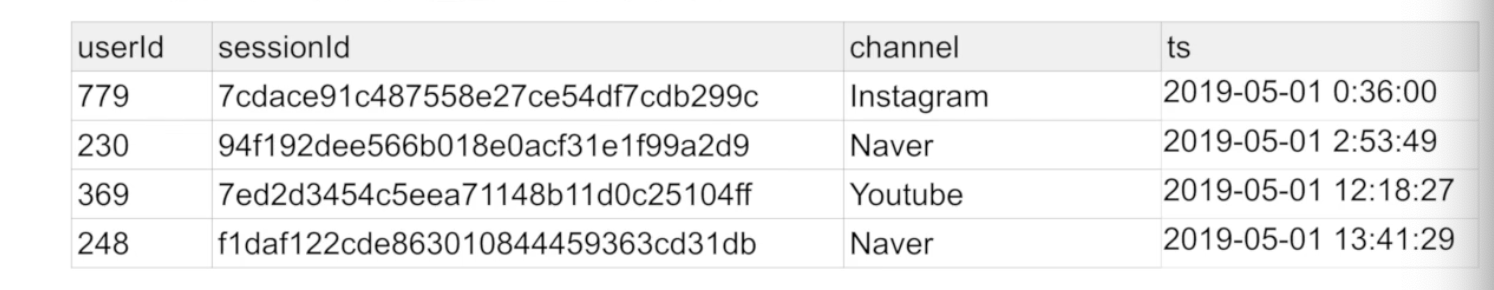

##  월별 유니크한 사용자 수 (2)
```sql
SELECT TO_CHAR(A.ts, "YYYY-MM") AS month, -- ts를 연도-월 형태로 바꾸어줌.
COUNT(DISTINCT B.userid) AS mau -- 유일 사용자 아이디만을 cnt
FROM raw_data.session_timestamp A
JOIN raw_data.user_session_channel B ON A.sessionid = B.sessionid -- A의 세션ID와 B의 세션ID가 같을 때 JOIN
GROUP BY 1
ORDER BY 1 DESC;
```

- 같은 구문 표현 : `TO_CHAR(A.ts, "YYYY-MM")`
- `LEFT(A.ts, 7)` : return - `str`
- `DATE_TRUNC(month', A.ts)` : '일'을 첫번째 날짜로 return 
- `SUBSTRING(A.ts, 1, 7)` - `str`
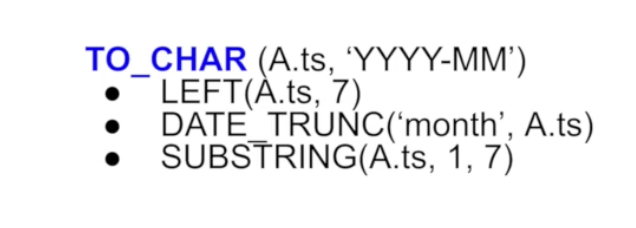

##  월별 유니크한 사용자 수 (3)
```sql
SELECT
TO_CHAR(A.ts, "YYYY-MM") AS month,
COUNT(DISTINCT B.userid) AS mau
FROM raw_data.session _timestamp A
JOIN raw _data.user _session_channel B ON A.sessionid = B.sessionid
GROUP BY 1
ORDER BY 1 DESC;
```

## 월별 유니크한 사용자 수 (4)
```sql
SELECT
TO_CHAR(A.ts, 'YYYY-MM') AS month,
COUNT(DISTINCT B.userid) AS mau
FROM raw_data.session _timestamp A
JOIN raw_data.user_session_channel B ON A.sessionid = B.sessionid
GROUP BY 1
ORDER BY 1 DESC;
```
- `INNER JOIN` VS `LEFT JOIN`


## 월별 유니크한 사용자 수 (5)
```sql
SELECT
TO_CHAR(A.ts,'YYYY-MM')AS month,
COUNT(DISTINCT B.userid)AS mau
FROM raw_data.session_timestamp A JOIN raw_data.user_session_channel B ON A.sessionid = B.sessionid
GROUP BY 1
ORDER BY 1 DESC;
```
- 필드/테이블 이름에 Alias 사용. AS는 필수가 아님.
- COUNT(DISTINCT B.userid) AS mau와 COUNT(DISTINCT B.userid) mau는 동일

## 월별 유니크한 사용자 수 (6)
```sql
SELECT
TO_CHAR(A.ts, 'YYYY-MM') AS month,
COUNT(DISTINCT B.userid) AS mau
FROM raw_data.session _timestamp A
JOIN raw_data.user_session_channel B ON A.sessionid = B.sessionid
GROUP BY 1
ORDER BY 1 DESC; - ASC
```
- ORDER BY와 GROUP BY:
    - 포지션 번호 vs. 필드 이름
- `GROUP BY 1` == `GROUP BY month` == `GROUP BY TO_CHAR(A.ts, 'YYYY-MM)`

## 월별 채널별 유니크한 사용자 수 (1)
- 필요한 정보 - 시간 정보, 사용자 정보, 채널 정보
- 먼저 어느 테이블을 사용해야하는지 생각!
    - user_session_channel (userld, sessionld, channel)?
    - session_timestamp (sessionld, ts)?
    - 혹은 이 2개의 테이블을 조인해야하나?

 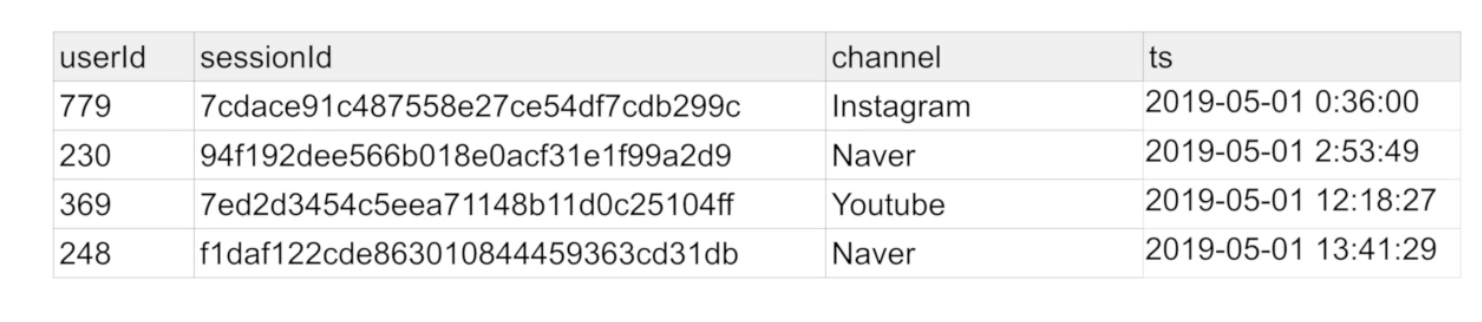
```sql
SELECT
TO_CHAR(A.ts, "YYYY-MM") AS month,
channel,
COUNT(DISTINCT B.userid) AS mau
FROM raw_dat.session_channel B ON A.sessionid = B.sessionid
GROUP BY 1, 2 --1번째, 2번째 열로 group by
ORDER BY 1 DESC, 2;
```

# CTAS: SELECT를 가지고 테이블 생성
- 간단하게 새로운 테이블을 만드는 방법
- 자주 조인하는 테이블들이 있다면 이를 CTAS를 사용해서 조인해두면 편리해짐
```sql
DROP TABLE IF EXISTS adhoc.keeyong_session _summary; -- adhoc 스키마에서 해당 테이블 존재한다면 사용, 예외가 떠도 아무런 일이 일어나지 않음.
```
```sql
CREATE TABLE adhoc.keeyong_session_summary AS SELECT B.*, A.ts FROM raw_data.session _timestamp A
JOIN raw_data.user_session_channel B ON A.sessionid = B.sessionid;
```

- 항상 시도해봐야하는 데이터 품질 확인 방법들
    - 중복된 레코드들 체크하기
    - 최근 데이터의 존재 여부 체크하기 (freshness)
        - Primary key uniqueness가 지켜지는지 체크하기
    - 값이 비어있는 컬럼들이 있는지 체크하기

## 중복된 레코드들 체크하기(1)
```sql
SELECT COUNT(1)
FROM adhoc.keeyong_session_summary;
```
```sql
SELECT COUNT(1)
FROM (
SELECT DISTINCT userld, sessionld, ts, channel
FROM adhoc.keeyong_session_summary
);
```

## 중복된 레코드들 체크하기 (2)
- CTE를 사용해서 중복 제거 후 카운트 해보기
```sql
With ds AS (
SELECT DISTINCT userld, sessionld, ts, channel FROM adhoc.keeyong_session_summary
) -- 재사용 가능 임시 테이블 생성 : CTE
SELECT COUNT(1)
FROM ds;
```

## 최근 데이터의 존재 여부 체크하기 (freshness)
```sql
SELECT MIN(ts), MAX(ts) -- 데이터의 기간 확인 
FROM adhoc.keeyong session summary;
```

## Primary key uniqueness가 지켜지는지 체크하기
```sql
SELECT sessionld, COUNT(1) -- id 수 count 
FROM adhoc.keeyong_session_summary
GROUP BY 1 -- 1보다 큰 수로 group by 됬다면 지켜지지 않음을 알 수 있다.
ORDER BY 2 DESC
LIMIT 1;
```

## 값이 비어있는 컬럼들이 있는지 체크하기
```sql
SELECT
    COUNT (CASE WHEN sessionld is NULL THEN 1. END) sessionid _null_count, -- 조건 만족 시 1을, 아니면 NULL을 return. 결국 NULL인 행들을 count
    COUNT (CASE WHEN userld is NULL THEN 1 END) userid _null count, 
    COUNT(CASE WHEN ts is NULL THEN 1 END)ts _null_ count,
    COUNT(CASE WHEN channel is NULL THEN 1 END) channel_null_count
FROM adhoc.keeyong_session_summary;
```